# Rossman Data Seti

Bu çalışmanın amacı Rossman mağzalarının günlük cirolarını tahmin eden bir model ortaya koymaktır. Veri ön işleme yapılıp, denetimli makine öğrenmesinin linear regresyon modelleri oluşturulacaktır.

In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV

In [2]:
df_zip=zipfile.ZipFile("C:/Users/okand/Desktop/projeler2/Rossman Sales/rossman.zip")
train=pd.read_csv(df_zip.open("train.csv"),low_memory=False)
store=pd.read_csv(df_zip.open("store.csv"),low_memory=False)

In [3]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Veri setinde ki özelliklerin tanımı:

## train dataset:
* store: mağaza idler
* DayOfWeek: haftanın gunu
* Date: Tarih
* Sales: Ciro (verilen tarihteki)
* Customers: Müşteri sayısı
* Open: mağazanın açık olup olmaması durumu
* Promo: O mağazanın o gün içerisinde kampanya yapıp yapmaması.
* StateHoliday: resmi tatil. (a=resmi tatil, b=pascalya, c=noel, 0= bunların dısında)
* SchoolHoliday: o bölgedeki okulların o tarihte açık olup olmaması

## store dataset:
* Store: mağaza id
* StoreType: Mağaza kategorileri (a,b,c,d)
* Assortment: Mağazaların ürün çeşitliliğini kategorize etmiş bir değişken. (a=temel ürünler, b=ekstra ürünler, c=genişletilmiş ürün yapısı)
* CompetitionDistance: Metre cinsinden veri. Rakip firmanın bize en yakın mağzasının bize olan uzaklığı.
* CompetitionOpenSinceMonth: En yakın rakip firmanın açıldığı ay
* CompetitionOpenSinceYear: En yakın rakip firmanın açıldığı yıl
* Promo2: Tüm mağzaları kapsayan promosyon yapısı (genel). Genel bir kampanya var ve her mağza buna katılmak zorunda değil. 0 katılmadı, 1 katıldı.
* Promo2SinceWeek: Promosyon sürecine katılınan hafta.
* Promo2SinceYear: Promosyon sürecine katılınan yıl.
* PromoInterval: Ay bazında promosyonun başlangıç ayları ve yenileme süreçleri.



In [5]:
veri=train.merge(store,on="Store",how="inner")
veri.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [6]:
veri.shape

(1017209, 18)

In [7]:
print("Toplam mağaza sayısı: {}".format(len(veri["Store"].unique())))
print("Günlük Ortalama Satış: {}".format(round(veri["Sales"].mean(),2)))
print("Mağaza Başına Günlük Ortalama Satış: {}".format(round(veri["Sales"].mean(),2)/len(veri["Store"].unique())))

Toplam mağaza sayısı: 1115
Günlük Ortalama Satış: 5773.82
Mağaza Başına Günlük Ortalama Satış: 5.178313901345291


In [8]:
# veri türleri düzenleme:
veri["Date"]=pd.to_datetime(veri["Date"],infer_datetime_format=True)
veri["Gün"]=veri["Date"].dt.day
veri["Hafta"]=veri["Date"].dt.week
veri["Ay"]=veri["Date"].dt.month
veri["Yıl"]=veri["Date"].dt.year
# Mevsimler:
veri["Mevsim"]=np.where(veri["Ay"].isin([3,4,5]),"İlkbahar",
                       np.where(veri["Ay"].isin([6,7,8]),"Yaz",
                               np.where(veri["Ay"].isin([9,10,11]),"Sonbahar",
                                       np.where(veri["Ay"].isin([12,1,2]),"Kış","None"))))

veri[["Date","Gün","Hafta","Ay","Yıl","Mevsim"]]

C:\Users\okand\AppData\Local\Temp\ipykernel_14928\4041994548.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  veri["Hafta"]=veri["Date"].dt.week


,Date,Gün,Hafta,Ay,Yıl,Mevsim
0,2015-07-31,31,31,7,2015,Yaz
1,2015-07-30,30,31,7,2015,Yaz
2,2015-07-29,29,31,7,2015,Yaz
3,2015-07-28,28,31,7,2015,Yaz
4,2015-07-27,27,31,7,2015,Yaz
...,...,...,...,...,...,...
1017204,2013-01-05,5,1,1,2013,Kış
1017205,2013-01-04,4,1,1,2013,Kış
1017206,2013-01-03,3,1,1,2013,Kış
1017207,2013-01-02,2,1,1,2013,Kış


In [9]:
veri.groupby("Yıl")["Sales"].sum()

Yıl
2013    2302876084
2014    2180804896
2015    1389499643
Name: Sales, dtype: int64

In [10]:
veri.groupby("Yıl")["Sales"].mean()

Yıl
2013    5658.533675
2014    5833.290704
2015    5878.245380
Name: Sales, dtype: float64

## Veri Görselleştirme:

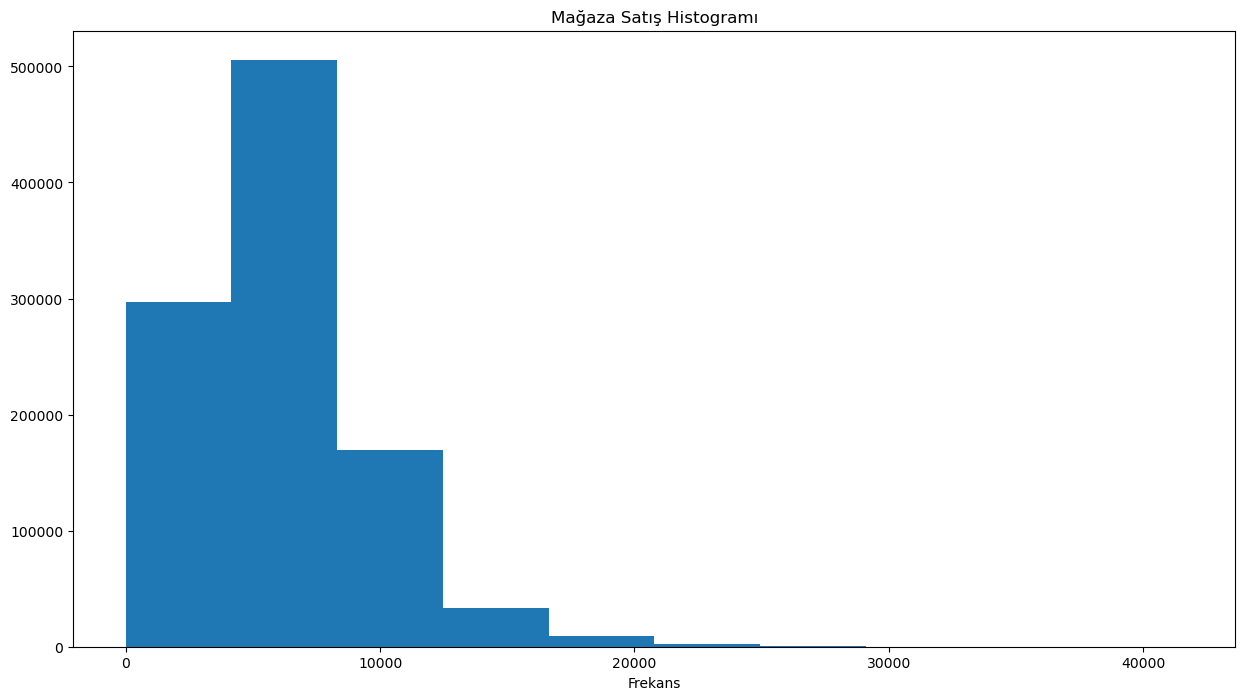

In [11]:
plt.figure(figsize=(15,8))
plt.hist(veri["Sales"])
plt.title("Mağaza Satış Histogramı")
plt.xlabel("Frekans")
plt.show()

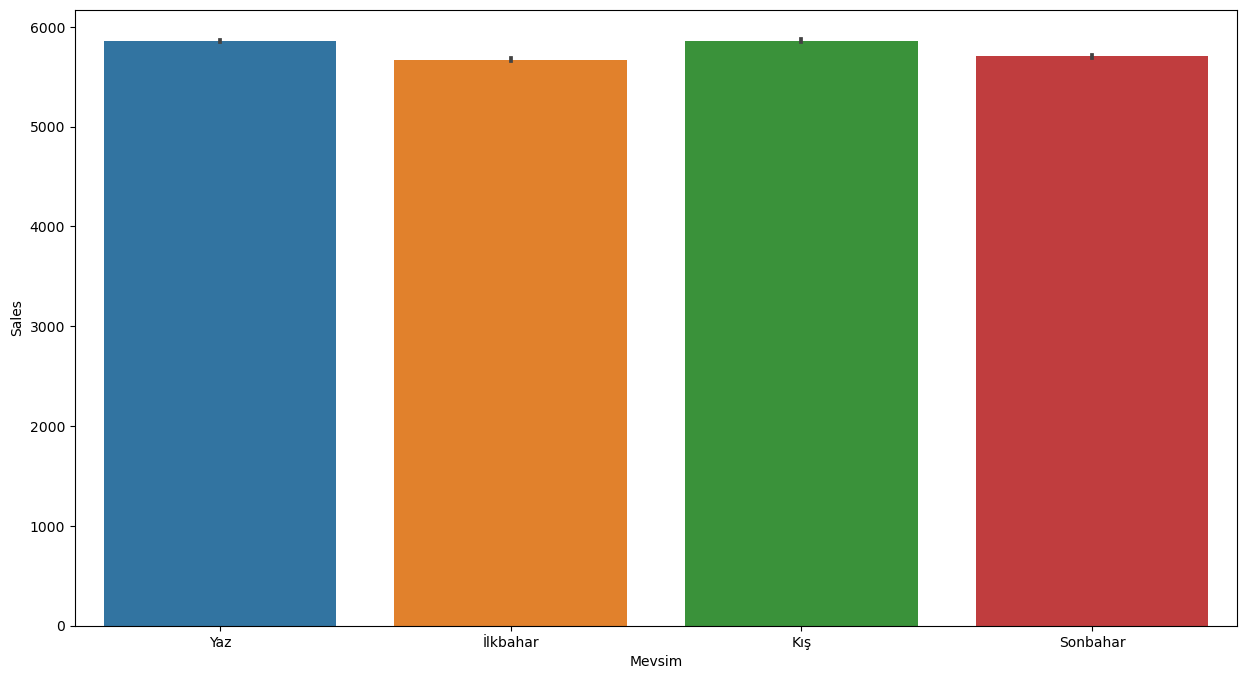

In [12]:
# mevsimlere göre satışlar
plt.figure(figsize=(15,8))
sns.barplot(x="Mevsim",y="Sales",data=veri)
plt.show()

In [13]:
veri.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Gün', 'Hafta', 'Ay', 'Yıl',
       'Mevsim'],
      dtype='object')

In [14]:
# eksik değer kontrolu:
veri.isnull().sum()/veri.shape[0]*100

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
Gün                           0.000000
Hafta                         0.000000
Ay                            0.000000
Yıl                           0.000000
Mevsim                        0.000000
dtype: float64

In [15]:
# mağaza tiplerinin sayısı:

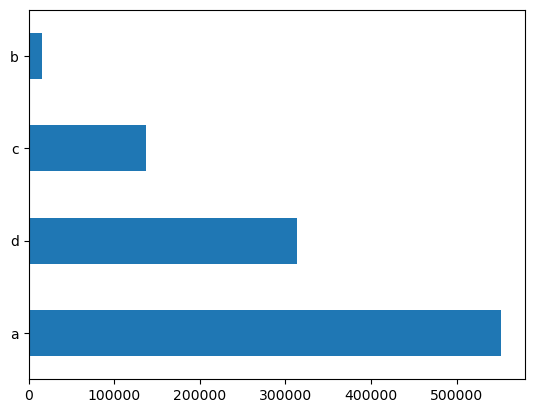

In [16]:
veri["StoreType"].value_counts().plot.barh();

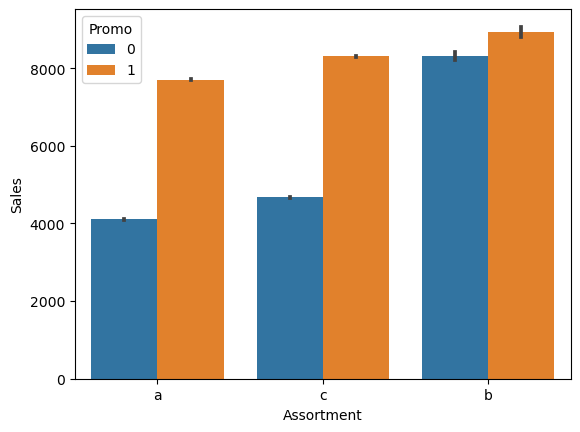

In [17]:
## Ürün çeşitliliğinin kampanya durumuna göre satış performansı:
# a: temel ürünler
# b: extra ürünler
# c: genişletilmiş ürün yapısı
sns.barplot(x="Assortment",y="Sales",hue="Promo",data=veri);

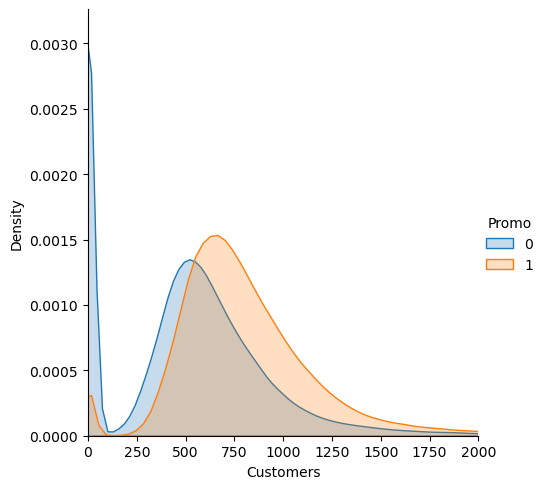

In [18]:
## Kampanya durumuna göre müşteri sayısı dağılımı:
(sns
 .FacetGrid(veri,
         hue="Promo",
         height=5,
         xlim=(0,2000))
 .map(sns.kdeplot,"Customers",shade=True)
 .add_legend()
);

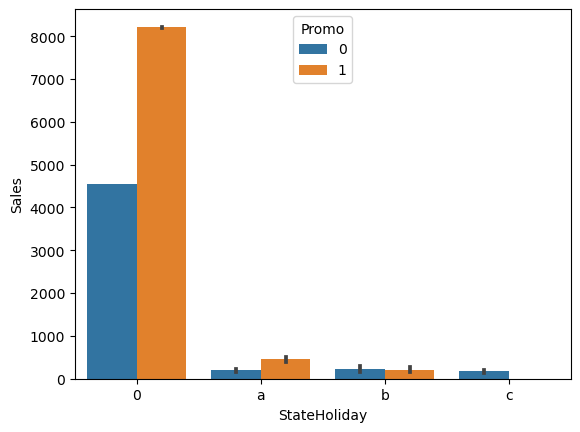

In [19]:
## Özel günlerin satışa etkisi:
sns.barplot(x="StateHoliday",y="Sales",hue="Promo",data=veri);

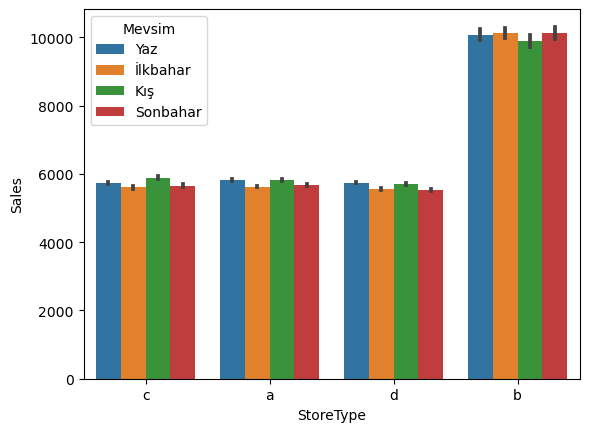

In [20]:
# Mevsimlere göre en çok satış yapan mağaza;
sns.barplot(x="StoreType",y="Sales",hue="Mevsim",data=veri);

# Eksik Değerler:

In [11]:
veri.isnull().sum()/veri.shape[0]*100

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
Gün                           0.000000
Hafta                         0.000000
Ay                            0.000000
Yıl                           0.000000
Mevsim                        0.000000
dtype: float64

In [12]:
veri["CompetitionDistance"]=veri["CompetitionDistance"].fillna(veri["CompetitionDistance"].mode()[0])

In [13]:
veri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

In [14]:
veri.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Gün,Hafta,Ay,Yıl,Mevsim
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,31,31,7,2015,Yaz
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,30,31,7,2015,Yaz
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,29,31,7,2015,Yaz
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,28,31,7,2015,Yaz
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,27,31,7,2015,Yaz
5,1,7,2015-07-26,0,0,0,0,0,0,c,...,2008.0,0,NaN,NaN,NaN,26,30,7,2015,Yaz
6,1,6,2015-07-25,4364,500,1,0,0,0,c,...,2008.0,0,NaN,NaN,NaN,25,30,7,2015,Yaz
7,1,5,2015-07-24,3706,459,1,0,0,0,c,...,2008.0,0,NaN,NaN,NaN,24,30,7,2015,Yaz
8,1,4,2015-07-23,3769,503,1,0,0,0,c,...,2008.0,0,NaN,NaN,NaN,23,30,7,2015,Yaz
9,1,3,2015-07-22,3464,463,1,0,0,0,c,...,2008.0,0,NaN,NaN,NaN,22,30,7,2015,Yaz


In [15]:
y=veri["Sales"]
nc=["Customers","Open","Promo","SchoolHoliday","CompetitionDistance","Promo2"] # sayısal değişkenler
kc=["DayOfWeek","StateHoliday","StoreType","Assortment","Hafta","Ay","Yıl","Mevsim"] # kategorik değişkenler

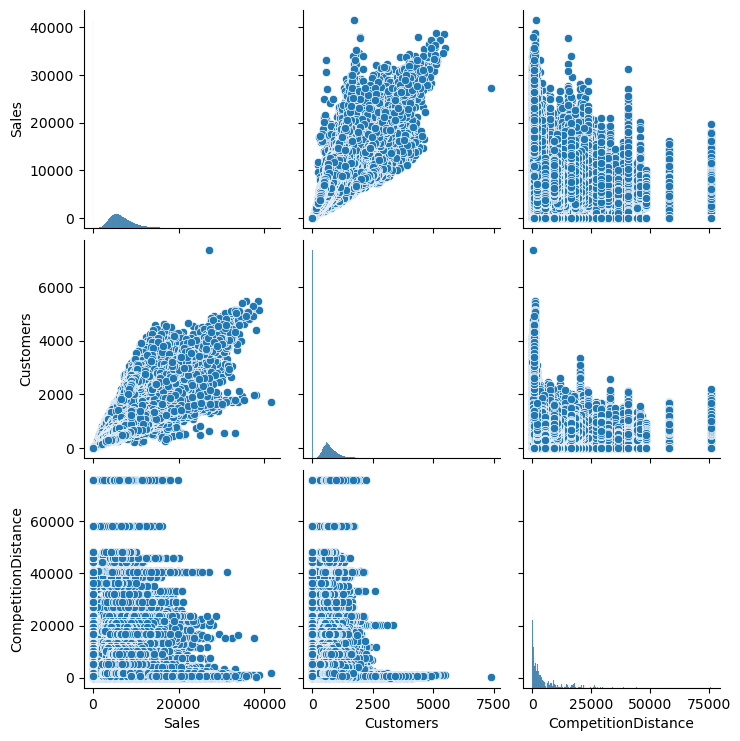

In [17]:
sns.pairplot(veri[["Sales","Customers","CompetitionDistance"]]);

Linear modeller veri adlı değişkende tuttuğumuz tüm veri seti üzeriden uygulanacaktır.

In [16]:
# Encoding:
def kategori(df,col):
    le=LabelEncoder()
    le1=le.fit_transform(df[col]).reshape(-1,1)
    oh=OneHotEncoder(sparse=False)
    sutunad=[col+" "+str(i) for i in le.classes_]
    return (pd.DataFrame(oh.fit_transform(le1),columns=sutunad))

t=veri[nc]

In [17]:
for column in kc:
    t_df=kategori(veri,column)
    t=pd.concat([t,t_df],axis=1)


In [18]:
t.columns[t.dtypes=="object"]

Index([], dtype='object')

In [25]:
t.head()

,Customers,CompetitionDistance,DayOfWeek 1,DayOfWeek 2,DayOfWeek 3,DayOfWeek 4,DayOfWeek 5,DayOfWeek 6,DayOfWeek 7,Open 0,...,Ay 12,Yıl 2013,Yıl 2014,Yıl 2015,Mevsim Kış,Mevsim Sonbahar,Mevsim Yaz,Mevsim İlkbahar,Promo2 0,Promo2 1
0,555,1270.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,546,1270.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,523,1270.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,560,1270.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,612,1270.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [19]:
## Standarlaştırma:
sc=StandardScaler()
X=sc.fit_transform(t)
X

array([[-0.16826876,  0.45239852,  1.27323691, ..., -0.47389949,
         1.69772048, -0.65860536],
       [-0.18764812,  0.45239852,  1.27323691, ..., -0.47389949,
         1.69772048, -0.65860536],
       [-0.23717316,  0.45239852,  1.27323691, ..., -0.47389949,
         1.69772048, -0.65860536],
       ...,
       [-0.71735076,  0.45239852, -0.78539979, ..., -0.47389949,
        -0.58902511, -0.65860536],
       [-0.70658445,  0.45239852, -0.78539979, ..., -0.47389949,
        -0.58902511, -0.65860536],
       [-1.36332959, -2.21044047, -0.78539979, ..., -0.47389949,
        -0.58902511, -0.65860536]])

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

# Model:

In [21]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor
import sklearn.metrics as mt
from sklearn.decomposition import PCA

In [22]:
def caprazdog(model):
    dogruluk=cross_val_score(model,X,y,cv=10)
    return dogruluk.mean()

def basari(gercek,tahmin):
    rmse=mt.mean_squared_error(gercek,tahmin,squared=True)
    r2=mt.r2_score(gercek,tahmin)
    return [rmse,r2]
    

In [39]:
lin_model=LinearRegression()
lin_model.fit(X_train,y_train)
lin_tahmin=lin_model.predict(X_test)

ridge_model=Ridge(alpha=0.1)
ridge_model.fit(X_train,y_train)
ridge_tahmin=ridge_model.predict(X_test)

lasso_model=Lasso(alpha=0.1)
lasso_model.fit(X_train,y_train)
lasso_tahmin=lasso_model.predict(X_test)

elas_model=ElasticNet(alpha=0.1)
elas_model.fit(X_train,y_train)
elas_tahmin=elas_model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.074e+10, tolerance: 1.208e+09
  model = cd_fast.enet_coordinate_descent(


In [40]:
sonuclar=[["Linear Model",basari(y_test,lin_tahmin)[0],basari(y_test,lin_tahmin)[1],caprazdog(lin_model)],
["Ridge Model",basari(y_test,ridge_tahmin)[0],basari(y_test,ridge_tahmin)[1],caprazdog(ridge_model)],
["Lasso Model",basari(y_test,lasso_tahmin)[0],basari(y_test,lasso_tahmin)[1],caprazdog(lasso_model)],
["ElasticNet Model",basari(y_test,elas_tahmin)[0],basari(y_test,elas_tahmin)[1],caprazdog(elas_model)]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.407e+10, tolerance: 1.384e+09
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.431e+10, tolerance: 1.386e+09
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.358e+10, toleranc

In [41]:
pd.options.display.float_format='{:,.4f}'.format
sonuclar=pd.DataFrame(sonuclar, columns=["Model","RMSE","R2","Doğrulama"])
print(sonuclar)

              Model           RMSE     R2  Doğrulama
0      Linear Model 1,367,828.6157 0.9072     0.9041
1       Ridge Model 1,367,872.7556 0.9072     0.9041
2       Lasso Model 1,367,839.3652 0.9072     0.9041
3  ElasticNet Model 1,423,329.5906 0.9034     0.9015


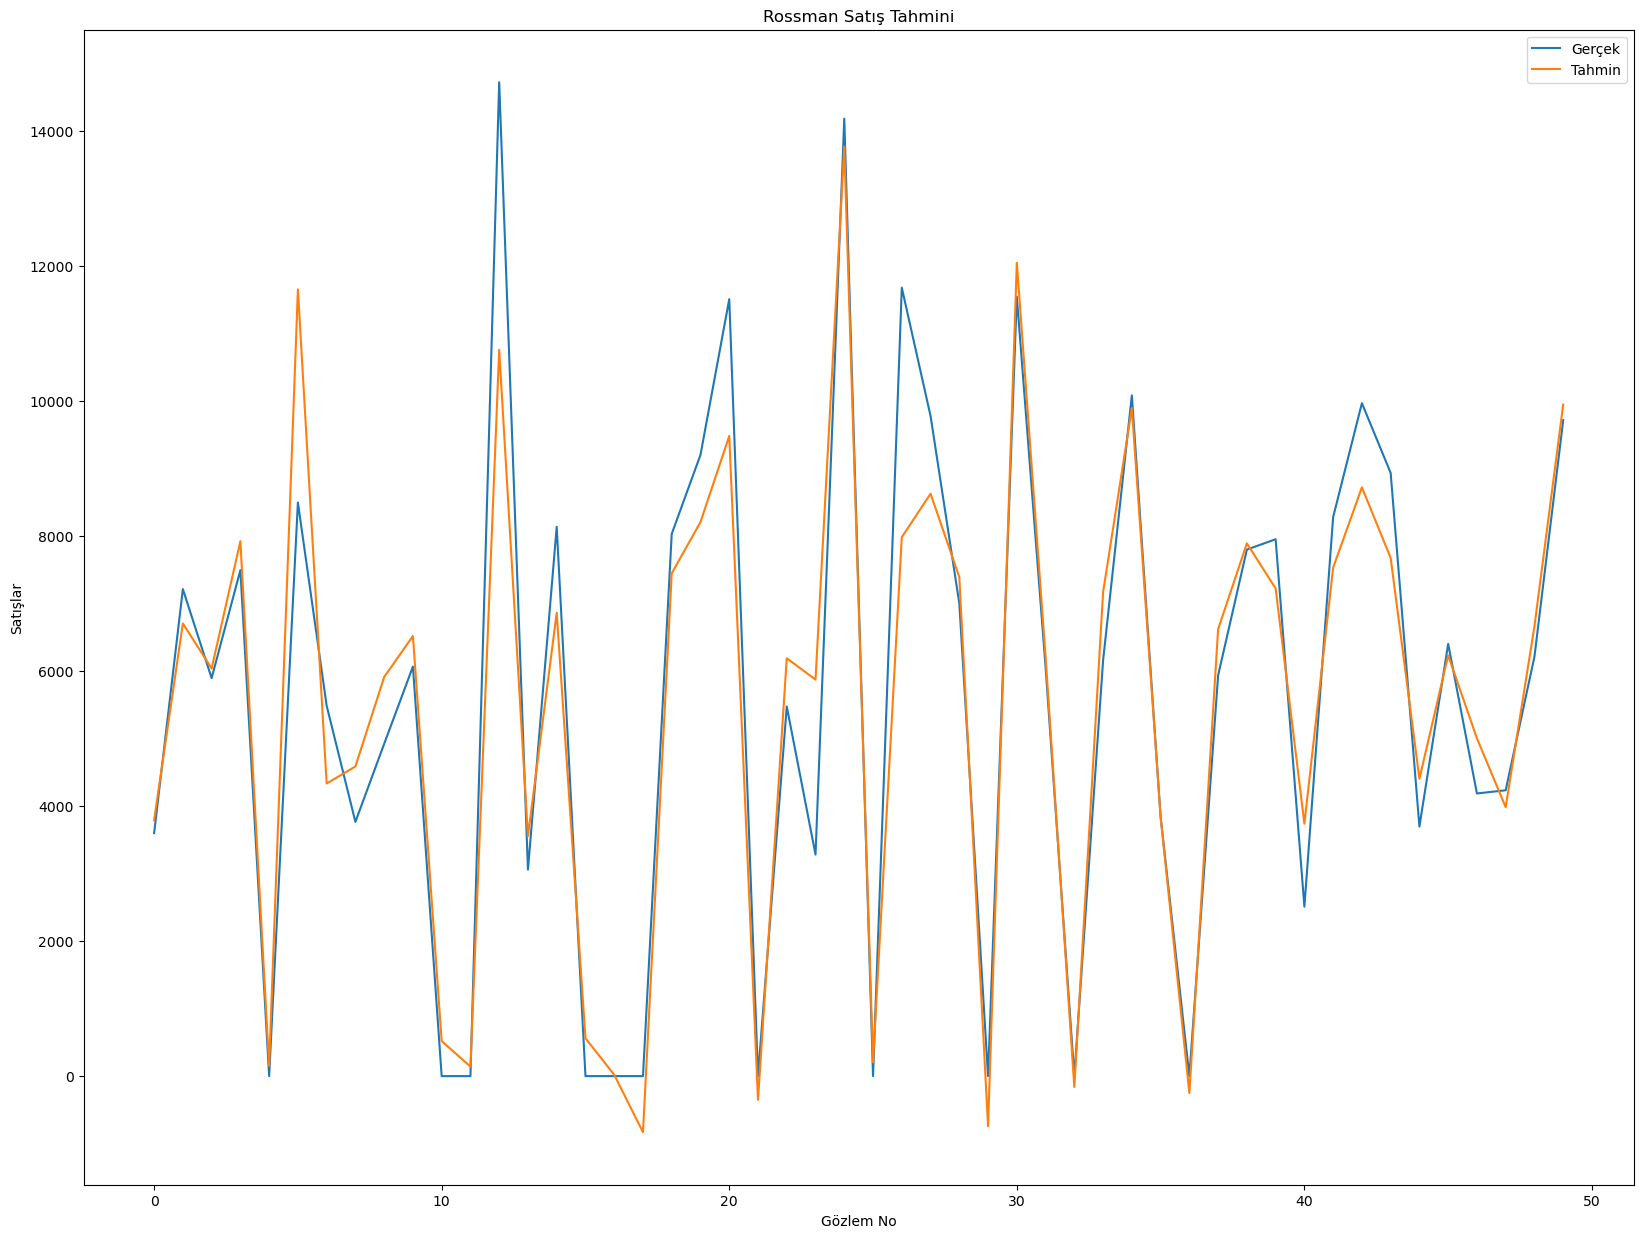

In [44]:
plt.figure(figsize=(20,15))
plt.plot(range(len(y_test[:50])),y_test[:50],label="Gerçek")
plt.plot(range(len(y_test[:50])),elas_tahmin[:50],label="Tahmin")
plt.title("Rossman Satış Tahmini")
plt.ylabel("Satışlar")
plt.xlabel("Gözlem No")
plt.legend()
plt.show()

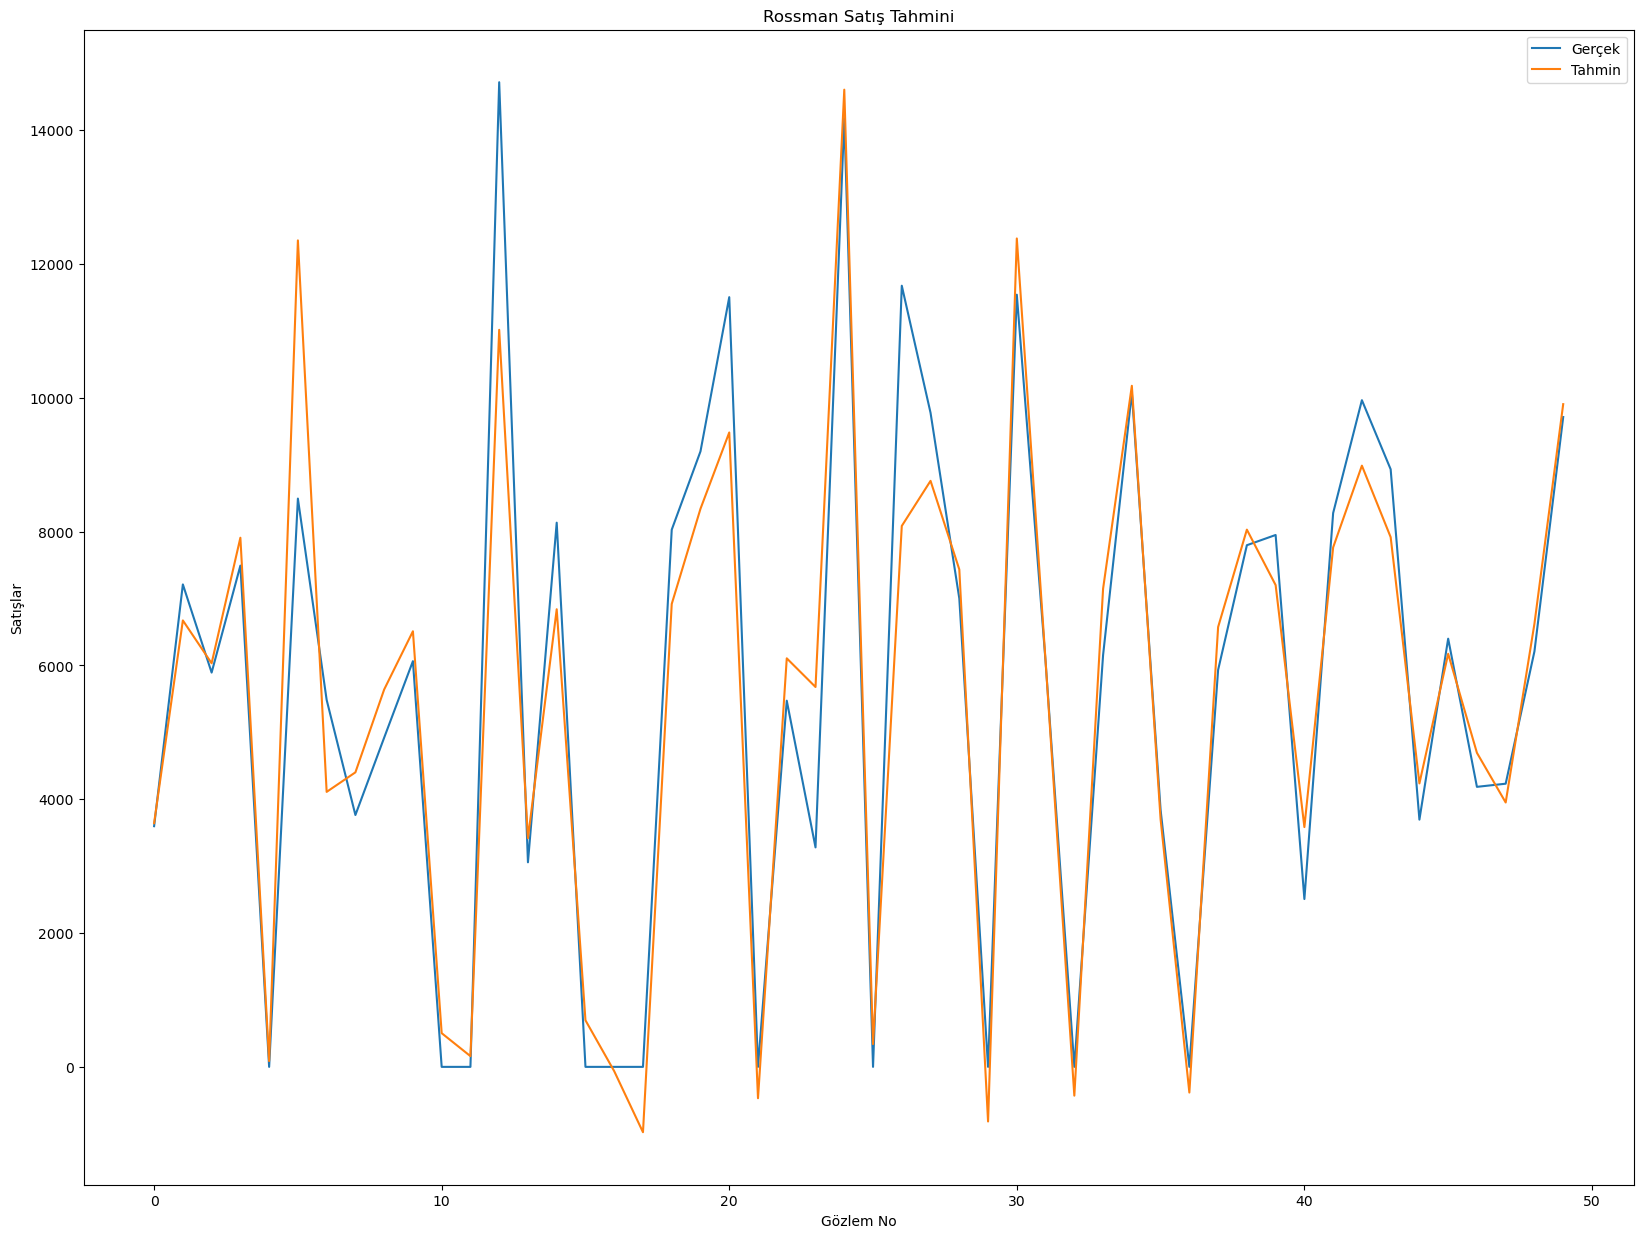

In [45]:
plt.figure(figsize=(20,15))
plt.plot(range(len(y_test[:50])),y_test[:50],label="Gerçek")
plt.plot(range(len(y_test[:50])),lin_tahmin[:50],label="Tahmin")
plt.title("Rossman Satış Tahmini")
plt.ylabel("Satışlar")
plt.xlabel("Gözlem No")
plt.legend()
plt.show()

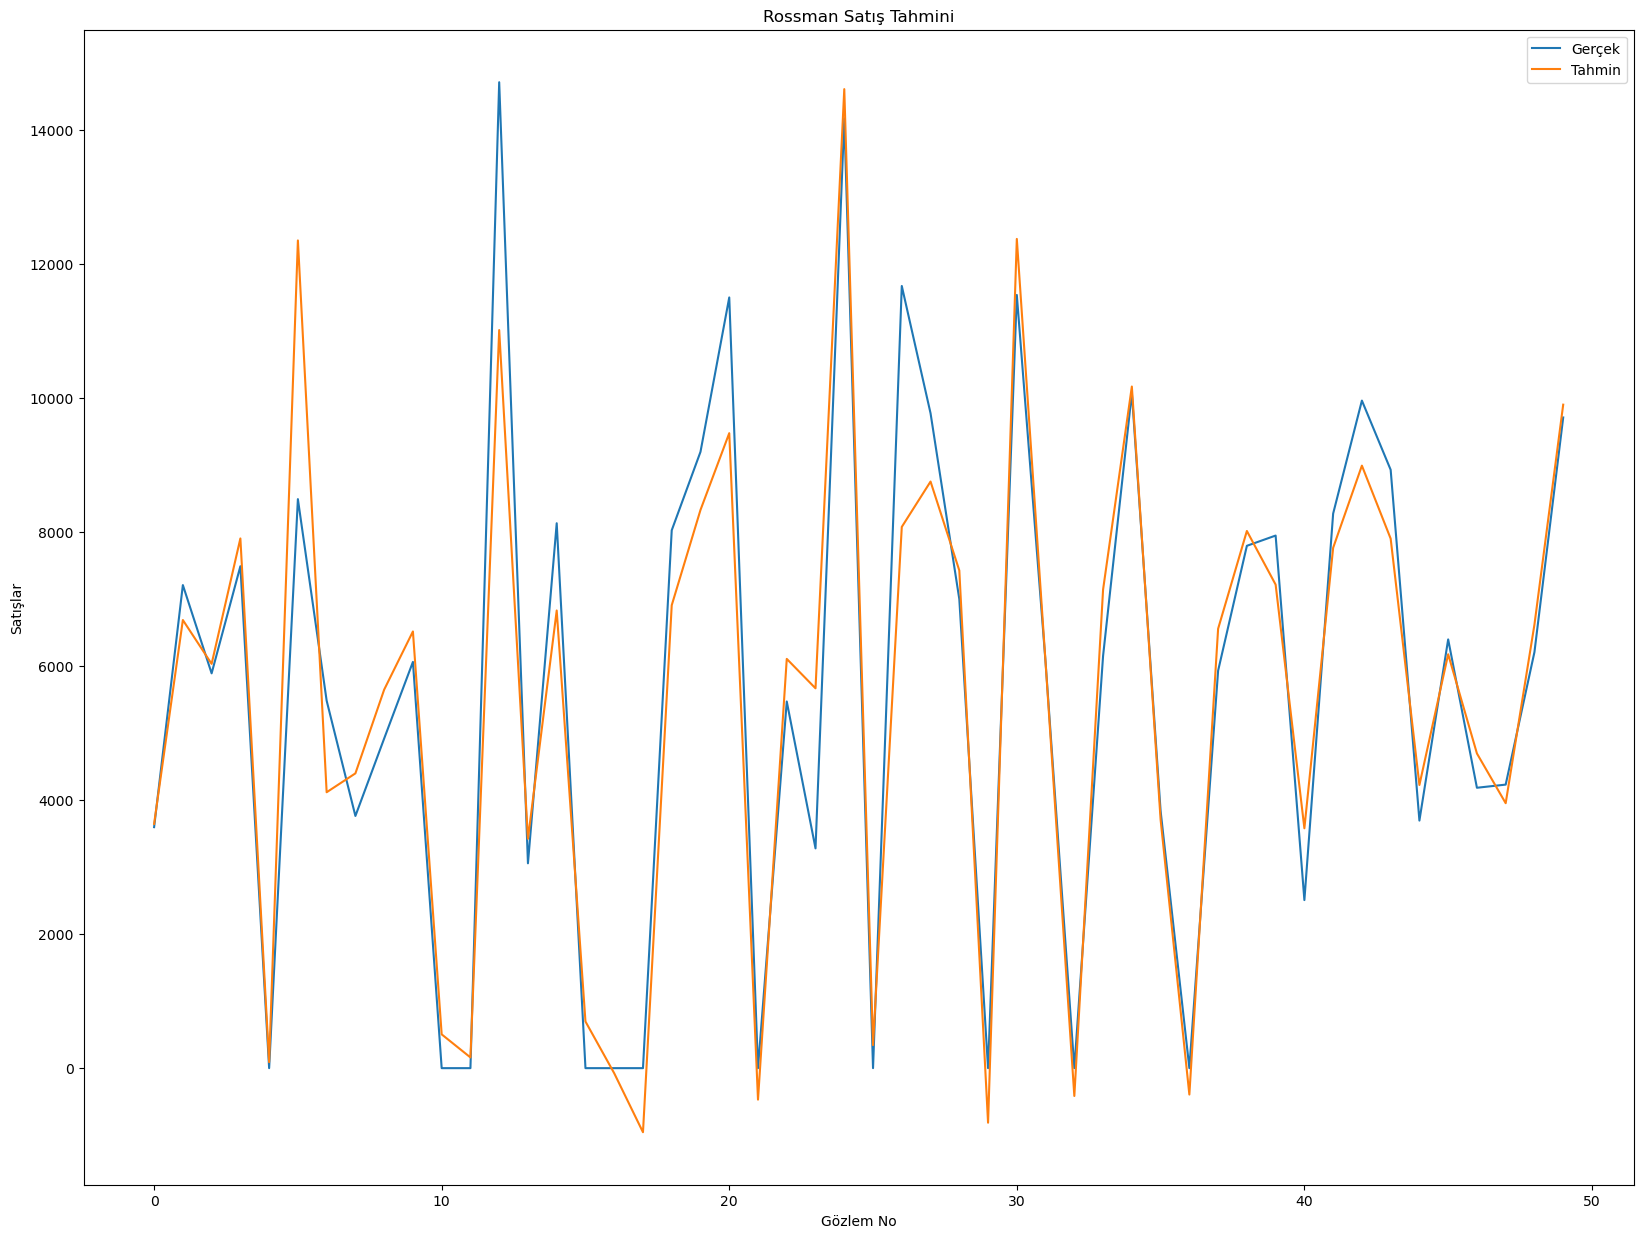

In [46]:
plt.figure(figsize=(20,15))
plt.plot(range(len(y_test[:50])),y_test[:50],label="Gerçek")
plt.plot(range(len(y_test[:50])),lasso_tahmin[:50],label="Tahmin")
plt.title("Rossman Satış Tahmini")
plt.ylabel("Satışlar")
plt.xlabel("Gözlem No")
plt.legend()
plt.show()

In [ ]:
t